In [1]:
from pathlib import Path
from XPINN import XPINN
import optax
from type_util import Array
from jax import jacobian, jit, vmap
import jax.numpy as np

In [2]:
file = Path("../data/advection_constraints.json")
xpinn = XPINN(file, np.tanh)

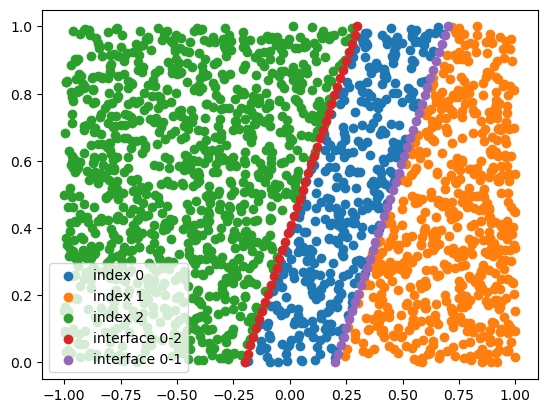

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

In [4]:
shapes = [[2, 10, 10, 1], [2, 50, 50, 1], [2, 100, 1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    optimizer = optax.adam(learning_rate=0.0003)

    pinn.init_params(shape, optimizer)
    print([x[0].shape for x in pinn.params])

[(10, 2), (10, 10), (1, 10)]
[(50, 2), (50, 50), (1, 50)]
[(100, 2), (1, 100)]


In [5]:
for pinn in xpinn.PINNs:
    print([x[0].shape for x in pinn.params])
    print(pinn.interior.shape)
    x = pinn.v_model(pinn.params, pinn.interior)
    print(x.shape)

[(10, 2), (10, 10), (1, 10)]
(372, 2)
(372, 1)
[(50, 2), (50, 50), (1, 50)]
(575, 2)
(575, 1)
[(100, 2), (1, 100)]
(1053, 2)
(1053, 1)


# Problem specifications
We consider the 1-D advection equation, defined by
$$
\begin{equation}
    u_t + 0.5 u_x = 0, \quad x \in [-1, 1], t \in [0, 1]
\end{equation}
$$
with the initial conditions
$$
\begin{cases}
    u(x, 0) = 1 & x \in [-0.2, 0.2] \\
    u(x, 0) = 0 & \text{otherwise}
\end{cases}
$$
In the middle PINN, we can set the boundary loss simply as
$$
\begin{equation}
    \lVert \mathcal{N}_{\theta}(x_b, 0) - 1 \rVert_2,
\end{equation}
$$
while for the left and right PINNs we set
$$
\begin{equation}
    \lVert \mathcal{N}_{\theta}(x_b, 0) \rVert_2,
\end{equation}
$$

In [6]:
def create_boundary_loss(index: int, target: float | Array):
    def boundary_loss(params, args):
        points = args["boundary"]
        eval = xpinn.PINNs[index].v_model(params, points)
        return np.mean((eval - target) ** 2)
        # return optax.l2_loss(eval, target)

    return boundary_loss


# fmt: off
def create_interior_loss(index: int):
    model = xpinn.PINNs[index].model
    jacob = lambda params: jacobian(lambda x: model(params, x))
    N_dt = lambda params, x: jacob(params)(x)[1]
    N_dx = lambda params, x: jacob(params)(x)[0]
    residual = lambda params, x: (N_dt(params, x) + 0.5 * N_dx(params, x)) ** 2
    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params, args):
        points = args["interior"]
        return np.mean(v_residual(params, points))

    return interior_loss
# fmt: on

In [7]:
in_size = xpinn.PINNs[0].input_size

p0, p1, p2 = xpinn.PINNs

p0.boundary_loss = create_boundary_loss(
    0,
    1.0,
)
p1.boundary_loss = create_boundary_loss(
    1,
    0.0,
)
p2.boundary_loss = create_boundary_loss(
    2,
    0.0,
)

In [8]:
# def inter_0(params, args):
#     int_01 = args["interface 01"]
#     res_1 = args["interface res 1"]
#     res_01 = np.sum((p0.v_residual(params, int_01) - res_1) ** 2)

#     val_1 = args["interface val 1"]
#     avg_01 = np.sum((p0.v_model(params, int_01) - val_1) ** 2)

#     int_02 = args["interface 02"]
#     res_2 = args["interface res 2"]
#     res_02 = np.sum((p0.v_residual(params, int_02) - res_2) ** 2)

#     val_2 = args["interface val 2"]
#     avg_02 = np.sum((p0.v_model(params, int_02) - val_2) ** 2)

#     return res_01 + avg_01 + res_02 + avg_02

In [9]:
def create_inter(i: int, j: int):

    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params, args):
        inter_points = args[f"interface {a}{b}"]
        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean((pi.v_model(params, inter_points) - val_j) ** 2)
        return res_ij + avg_ij

    return interface_loss

In [10]:
p0.interface_loss = lambda params, args: create_inter(0, 1)(
    params, args
) + create_inter(0, 2)(params, args)
p1.interface_loss = lambda params, args: create_inter(1, 0)(params, args)
p2.interface_loss = lambda params, args: create_inter(2, 0)(params, args)

In [11]:
p0.create_loss()
p1.create_loss()
p2_loss = p2.create_loss()

In [12]:
from jax import grad

grad(p2_loss)

<function XPINN.PINN.create_loss.<locals>.loss(params: Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, Iterable[ForwardRef('ArrayTree')], Mapping[Any, ForwardRef('ArrayTree')]], args: dict[str, jax.Array]) -> float>

In [13]:
losses = xpinn.run_iters(10000)

0.00% iter = 0 of 10000
10.00% iter = 1000 of 10000
20.00% iter = 2000 of 10000
30.00% iter = 3000 of 10000
40.00% iter = 4000 of 10000
50.00% iter = 5000 of 10000
60.00% iter = 6000 of 10000
70.00% iter = 7000 of 10000
80.00% iter = 8000 of 10000
90.00% iter = 9000 of 10000


Text(0.5, 1.0, 'Loss per Pinn over 10000 epochs')

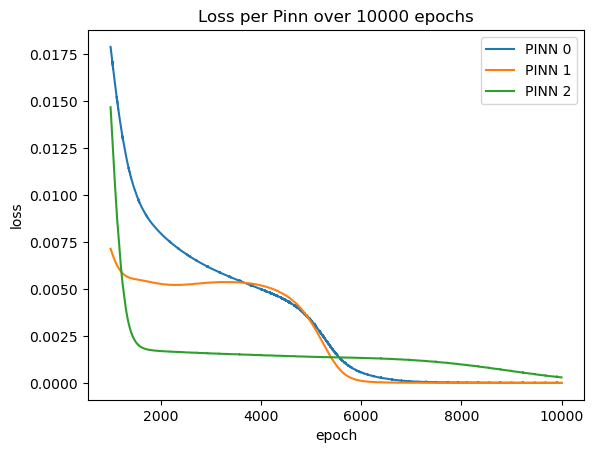

In [21]:
a_losses = np.asarray(losses).T
t = np.arange(1000, 10000)

for i in range(3):
    plt.plot(t, a_losses[i, 1000:], label=f"PINN {i}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title(f"Loss per Pinn over {10000} epochs")

In [15]:
losses

[[Array(0.98679256, dtype=float32),
  Array(0.0003132, dtype=float32),
  Array(0.00057501, dtype=float32)],
 [Array(0.9860454, dtype=float32),
  Array(0.00028013, dtype=float32),
  Array(0.00053027, dtype=float32)],
 [Array(0.9853012, dtype=float32),
  Array(0.00024962, dtype=float32),
  Array(0.00048796, dtype=float32)],
 [Array(0.98455876, dtype=float32),
  Array(0.00022167, dtype=float32),
  Array(0.00044809, dtype=float32)],
 [Array(0.9838183, dtype=float32),
  Array(0.00019627, dtype=float32),
  Array(0.00041068, dtype=float32)],
 [Array(0.9830797, dtype=float32),
  Array(0.0001734, dtype=float32),
  Array(0.00037575, dtype=float32)],
 [Array(0.98234266, dtype=float32),
  Array(0.00015306, dtype=float32),
  Array(0.0003433, dtype=float32)],
 [Array(0.981607, dtype=float32),
  Array(0.00013523, dtype=float32),
  Array(0.00031335, dtype=float32)],
 [Array(0.9808726, dtype=float32),
  Array(0.00011991, dtype=float32),
  Array(0.00028591, dtype=float32)],
 [Array(0.98013884, dtype=flo